In [60]:
import os, sys
import numpy as np
from math import *
from tqdm import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf

from scipy import stats

import pickle



from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

from spektral.layers import ECCConv, GlobalAvgPool, MessagePassing, XENetConv, GlobalAttentionPool, GlobalMaxPool, GlobalSumPool,GlobalAttnSumPool


plt.style.use('ggplot')
plt.style.use('seaborn-paper') 
plt.style.use('seaborn-whitegrid') 

In [61]:
train_dir = 'train_datasets/'
valid_dir = 'valid_datasets/'

BATCH_SIZE=32
EPOCHS=2

all_file_list = [train_dir + filename for filename in os.listdir(train_dir)]

dataset_size = sum(1 for _ in tf.data.TFRecordDataset(all_file_list[0]))*len(all_file_list)//BATCH_SIZE


feature_description = {'group_id': tf.io.FixedLenFeature([], tf.int64),
                        'timestep': tf.io.FixedLenFeature([], tf.int64),
                        'parameter_vector': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),
                        'pos': tf.io.FixedLenFeature([], tf.string),
                        'vel': tf.io.FixedLenFeature([], tf.string),
                        'acc': tf.io.FixedLenFeature([], tf.string)}

def _parse_record(x):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(x, feature_description)

def _parse_tensor(x):
    output = {'group_id': x['group_id'],
                'timestep': x['timestep'],
                'parameter_vector': x['parameter_vector'],
                'pos': tf.io.parse_tensor(x['pos'],out_type=tf.float32),
                'vel': tf.io.parse_tensor(x['vel'],out_type=tf.float32),
                'acc': tf.io.parse_tensor(x['acc'],out_type=tf.float32)}
    return output

def _parse_keras(x):
    pos = x['pos']
    pos.set_shape((None,2))
    vel = x['vel']
    vel.set_shape((None,2))
    acc = x['acc']
    acc.set_shape((None,2))
    
    target = x['parameter_vector']
    target.set_shape((4))
    output = ((pos,vel,acc),target)
    return output

DOMAIN_SIZE=200
max_params = np.array([5.0, 25.0,25.0,2*pi],dtype=np.float32)

def _parse_graph(inputs, targets):
    #inputs, targets = x
    X, V, A = inputs
    
    Xx = tf.expand_dims(X[...,0],-1)
    dx = -Xx + tf.linalg.matrix_transpose(Xx)
    dx = tf.where(dx>0.5*DOMAIN_SIZE, dx-DOMAIN_SIZE, dx)
    dx = tf.where(dx<-0.5*DOMAIN_SIZE, dx+DOMAIN_SIZE, dx)

    Xy = tf.expand_dims(X[...,1],-1)
    dy = -Xy + tf.linalg.matrix_transpose(Xy)
    dy = tf.where(dy>0.5*DOMAIN_SIZE, dy-DOMAIN_SIZE, dy)
    dy = tf.where(dy<-0.5*DOMAIN_SIZE, dy+DOMAIN_SIZE, dy)

    Vx = tf.expand_dims(V[...,0],-1)
    dvx = -Vx + tf.linalg.matrix_transpose(Vx)

    Vy = tf.expand_dims(V[...,1],-1)
    dvy = -Vy + tf.linalg.matrix_transpose(Vy)
    
    dvnorm = tf.math.sqrt(dvx**2+dvy**2)
    dvx = tf.math.divide_no_nan(dvx,dvnorm)
    dvy = tf.math.divide_no_nan(dvy,dvnorm)

    angles = tf.expand_dims(tf.math.atan2(V[...,1],V[...,0]),-1)
    angle_to_neigh = tf.math.atan2(dy, dx)

    rel_angle_to_neigh = angle_to_neigh - angles

    dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))

    interaction_radius = 25.0# tf.reduce_mean(dist,axis=[1,2],keepdims=True)
    adj_matrix = tf.where(dist<interaction_radius, tf.ones_like(dist,dtype=tf.int32), tf.zeros_like(dist,dtype=tf.int32))
    adj_matrix = tf.linalg.set_diag(adj_matrix, tf.zeros(tf.shape(adj_matrix)[:2],dtype=tf.int32))
    sender_recv_list = tf.where(adj_matrix)
    n_edge = tf.reduce_sum(adj_matrix, axis=[1,2])
    n_node = tf.ones_like(n_edge)*tf.shape(adj_matrix)[-1]

    output_i = tf.repeat(tf.range(tf.shape(adj_matrix)[0]),n_node)
    output_ie = tf.repeat(tf.range(tf.shape(adj_matrix)[0]),n_edge)


    senders =tf.squeeze(tf.slice(sender_recv_list,(0,1),size=(-1,1)))+ tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]
    receivers = tf.squeeze(tf.slice(sender_recv_list,(0,2),size=(-1,1))) + tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]

    output_a = tf.sparse.SparseTensor(indices=tf.stack([senders,receivers],axis=1), values = tf.ones_like(senders),dense_shape=[tf.shape(output_i)[0],tf.shape(output_i)[0]])
    edge_distance = tf.expand_dims(tf.gather_nd(dist/interaction_radius, sender_recv_list),-1)
    edge_x_distance =  tf.expand_dims(tf.gather_nd(tf.math.cos(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading
    edge_y_distance =  tf.expand_dims(tf.gather_nd(tf.math.sin(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading

    edge_x_orientation =  tf.expand_dims(tf.gather_nd(dvx,sender_recv_list),-1)  # neigbour velocity relative to sender heading
    edge_y_orientation =  tf.expand_dims(tf.gather_nd(dvy,sender_recv_list),-1)  # neigbour velocity relative to sender heading


    output_e = tf.concat([edge_distance,edge_x_distance,edge_y_distance,edge_x_orientation,edge_y_orientation],axis=-1)

    node_velocities = tf.reshape(V,(-1,2))
    node_accelerations = tf.reshape(A,(-1,2))

    output_x = tf.concat([node_velocities,node_accelerations],axis=-1)
    #dist = tf.linalg.set_diag(dist, 25.0*tf.ones(tf.shape(dist)[:2],dtype=tf.float32))

    #dist_out =  tf.reduce_mean(tf.reduce_min(dist,axis=[2]),axis=[1])
    return (output_x, output_a, output_e, output_i,output_ie), targets/max_params#, tf.ones_like(targets)/max_params
    
    
    

train_dataset =  tf.data.TFRecordDataset(tf.data.Dataset.list_files([train_dir + filename for filename in os.listdir(train_dir)]))

parsed_train_dataset = train_dataset.map(_parse_record)
parsed_train_dataset = parsed_train_dataset.map(_parse_tensor)
parsed_train_dataset = parsed_train_dataset.map(_parse_keras)


parsed_train_dataset = parsed_train_dataset.shuffle(10000, reshuffle_each_iteration=True)
parsed_train_dataset = parsed_train_dataset.repeat(EPOCHS)
parsed_train_dataset = parsed_train_dataset.batch(BATCH_SIZE, drop_remainder=True)

parsed_train_dataset = parsed_train_dataset.map(_parse_graph)


valid_dataset =  tf.data.TFRecordDataset(tf.data.Dataset.list_files([valid_dir + filename for filename in os.listdir(valid_dir)]))

parsed_valid_dataset = valid_dataset.map(_parse_record)
parsed_valid_dataset = parsed_valid_dataset.map(_parse_tensor)
parsed_valid_dataset = parsed_valid_dataset.map(_parse_keras)
#parsed_valid_dataset = parsed_valid_dataset.shuffle(10000, reshuffle_each_iteration=True)
parsed_valid_dataset = parsed_valid_dataset.batch(BATCH_SIZE, drop_remainder=True)
parsed_valid_dataset = parsed_valid_dataset.map(_parse_graph)




In [62]:
# max_params

# databatch[1][:,0]

128/4

32.0

In [129]:
n_out = 4
n_feat_node=4
n_feat_edge=5

MLP_SIZE=16

X_in = Input(shape=(n_feat_node,))
A_in = Input(shape=(None,), sparse=True)
E_in = Input(shape=(n_feat_edge,))
I_in = Input(shape=(), dtype=tf.int64)
IE_in = Input(shape=(), dtype=tf.int64)



X = Dense(MLP_SIZE, activation="linear")(X_in)
E = Dense(MLP_SIZE, activation="linear")(E_in)

# X = Concatenate()([X, X_in])
# E = Concatenate()([E, E_in])


mp_steps = 3

#XEMP_layer = XENetConv(32, 16, 16, node_activation="relu", edge_activation="relu")
#for _ in range(mp_steps):

#    X, E = XEMP_layer([X, A_in, E])
# X, E = XENetConv([8,8], 8, 8)([X, A_in, E])
# X, E = XENetConv(8, 8, 8)([X, A_in, E])
# X, E = XENetConv(8, 8, 8)([X, A_in, E])

## below works well
# X, E = XENetConv([16,16], 32, 16, node_activation="tanh", edge_activation="tanh")([X, A_in, E])
# X, E = XENetConv([16,16], 32, 16, node_activation="tanh", edge_activation="tanh")([X, A_in, E])


X, E = XENetConv([MLP_SIZE,MLP_SIZE], MLP_SIZE, 2*MLP_SIZE, node_activation="relu", edge_activation="relu")([X, A_in, E])
X, E = XENetConv([MLP_SIZE,MLP_SIZE], MLP_SIZE, 2*MLP_SIZE, node_activation="relu", edge_activation="relu")([X, A_in, E])
#X, E = XENetConv([16,16], 32, 16, node_activation="relu", edge_activation="relu")([X, A_in, E])


#X, E = XENetConv(2, 4, 5, node_activation="tanh", edge_activation="tanh")([X, A_in, E])
#X, E = XENetConv(2, 4, 5, node_activation="tanh", edge_activation="tanh")([X, A_in, E])


#X, E = XENetConv(5, 10, 10, node_activation="tanh", edge_activation="tanh")([X, A_in, E])
#X, E = XENetConv(5, 10, 10, node_activation="tanh", edge_activation="tanh")([X, A_in, E])
#X, E = XENetConv(5, 10, 10, node_activation="tanh", edge_activation="tanh")([X, A_in, E])


#X, E = XENetConv(4, 8, 8, False, node_activation="tanh", edge_activation="tanh")([X, A_in, E])
#X, E = XENetConv(4, 8, 8, False, node_activation="tanh", edge_activation="tanh")([X, A_in, E])
#X, E = XENetConv(4, 8, 8, False, node_activation="tanh", edge_activation="tanh")([X, A_in, E])
#X, E = XENetConv(4, 8, 8, False, node_activation="tanh", edge_activation="tanh")([X, A_in, E])
#X, E = XENetConv(4, 8, 8, False, node_activation="tanh", edge_activation="tanh")([X, A_in, E])

X = Dense(MLP_SIZE, activation="linear",use_bias=False)(X)
E = Dense(MLP_SIZE, activation="linear",use_bias=False)(E)


#X_2 = ECCConv(32, activation="relu")([X_1, A_in, E_1])
#X_3 = ECCConv(32, activation="relu")([X_2, A_in, E_1])

X = Concatenate()([X, X_in])
E = Concatenate()([E, E_in])
#X = Dense(16, activation="linear",use_bias=False)(X)

Xs = GlobalAttnSumPool()([X, I_in])
Xm = GlobalMaxPool()([X, I_in])
Xp = GlobalAttentionPool(MLP_SIZE)([X, I_in])
Xa = GlobalAvgPool()([X, I_in])

Es = GlobalAttnSumPool()([E, IE_in])
Em = GlobalMaxPool()([E, IE_in])
Ep = GlobalAttentionPool(MLP_SIZE)([E, IE_in])
Ea = GlobalAvgPool()([E, IE_in])

#X = Concatenate()([Xs, Xm, Xp, Xa, Es, Em, Ep, Ea])
X = Concatenate()([Xs,Xm,Xa, Es,Em,Ea])


# E = GlobalAttentionPool(16)([E,IE_in])

# X = Concatenate()([X, X_in])
# X = GlobalAttentionPool(16)([X,I_in])

# X = Concatenate()([X, E])
X = Dense(MLP_SIZE, activation="linear",use_bias=False)(X)

output = Dense(n_out, activation="relu",use_bias=False)(X)

gnn_model = Model(inputs=[X_in, A_in, E_in, I_in, IE_in], outputs=output)


In [130]:

gnn_model.summary()

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_146 (InputLayer)          [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_148 (InputLayer)          [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_166 (Dense)               (None, 16)           80          input_146[0][0]                  
__________________________________________________________________________________________________
input_147 (InputLayer)          [(None, None)]       0                                            
___________________________________________________________________________________________

In [131]:
learning_rate = 1e-3# Learning rate
gnn_model.compile(optimizer=Adam(learning_rate), loss="mse")



Epoch 1/2


/maths/ctorney/anaconda3/envs/tf_pre/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_29/xe_net_conv_63/Reshape_7:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_29/xe_net_conv_63/Reshape_6:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/model_29/xe_net_conv_63/Cast_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/maths/ctorney/anaconda3/envs/tf_pre/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_29/xe_net_conv_62/Reshape_7:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_29/xe_net_conv_62/Reshape_6:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradient_tape/model_29/xe_net_conv_62/Cast

55625/55625 [==============================] - 1719s 31ms/step - loss: 0.0125 - val_loss: 0.0138
Epoch 2/2
55625/55625 [==============================] - 1717s 31ms/step - loss: 0.0072 - val_loss: 0.0122


6875it [06:06, 18.78it/s]


validation loss 0.012153175169026309


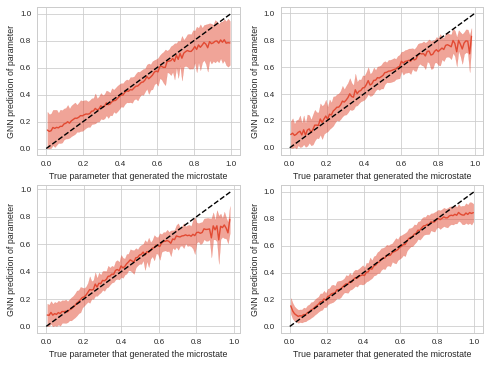

Epoch 1/2
55625/55625 [==============================] - 1718s 31ms/step - loss: 0.0062 - val_loss: 0.0113
Epoch 2/2
55625/55625 [==============================] - 1722s 31ms/step - loss: 0.0058 - val_loss: 0.0109


6875it [06:05, 18.82it/s]


validation loss 0.010872085796381261


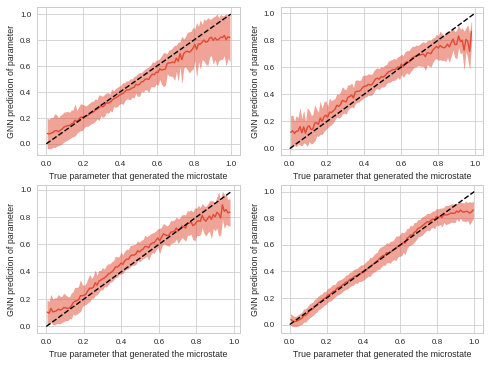

Epoch 1/2
55625/55625 [==============================] - 1716s 31ms/step - loss: 0.0054 - val_loss: 0.0118
Epoch 2/2
43027/55625 [======================>.......] - ETA: 5:50 - loss: 0.0052

In [ ]:
for run in range(20):
    gnn_model.fit(parsed_train_dataset, steps_per_epoch=dataset_size, epochs=EPOCHS,validation_data=parsed_valid_dataset)
    valid_loss = 0
    
    
    c = 0
    pred_list = []
    true_values = []
    for databatch in tqdm(parsed_valid_dataset):

        target = databatch[1]
        true_values.append(target.numpy())


        predictions = gnn_model(databatch[0])
        pred_list.append(np.squeeze(predictions.numpy()))

        loss_value = tf.keras.losses.MeanSquaredError()(target,predictions).numpy()
        valid_loss+= loss_value
        c+=1



    print('validation loss', valid_loss/c)

    fig, axs = plt.subplots(2,2, figsize=(8, 6), facecolor='w', edgecolor='k')  

    axs = axs.ravel()
    for pred_i in range(4):

        pred_vals = np.array([pp[:,pred_i] for pp in pred_list]).flatten()
        true_vals = np.array([tt[:,pred_i] for tt in true_values]).flatten()

        bin_means, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,bins=100)
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2

        bin_stds, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,statistic='std',bins=100)


        axs[pred_i].plot(bin_centers,bin_means,c='C0')

        axs[pred_i].fill_between(bin_centers,bin_means-bin_stds,bin_means+bin_stds,color='C0',alpha=0.5)

        xx = np.linspace(0,true_vals.max(),10)
        axs[pred_i].plot(xx,xx,c='k',ls='--')

        axs[pred_i].set_ylabel('GNN prediction of parameter')
        axs[pred_i].set_xlabel('True parameter that generated the microstate')



    plt.savefig('gnn_' + str(run) + '.png',dpi=300)
    plt.show()

In [59]:
#gnn_model.fit(parsed_train_dataset, steps_per_epoch=dataset_size, epochs=EPOCHS,validation_data=parsed_valid_dataset)

print('validation loss', valid_loss/c)


validation loss 0.0073702722705816


1000it [00:49, 20.04it/s]


validation loss 0.037248379469930114


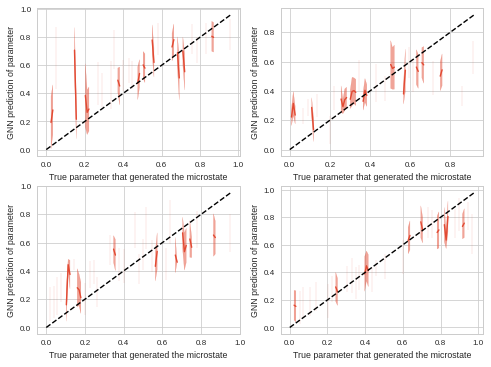

In [90]:
valid_loss = 0
c = 0
pred_list = []
true_values = []
for databatch in tqdm(parsed_train_dataset):

    target = databatch[1]
    true_values.append(target.numpy())


    predictions = gnn_model(databatch[0])
    pred_list.append(np.squeeze(predictions.numpy()))

    loss_value = tf.keras.losses.MeanSquaredError()(target,predictions).numpy()
    valid_loss+= loss_value
    c+=1
    if c>1000: break



print('validation loss', valid_loss/c)

fig, axs = plt.subplots(2,2, figsize=(8, 6), facecolor='w', edgecolor='k')  

axs = axs.ravel()
for pred_i in range(4):

    pred_vals = np.array([pp[:,pred_i] for pp in pred_list]).flatten()
    true_vals = np.array([tt[:,pred_i] for tt in true_values]).flatten()

    bin_means, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,bins=100)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    bin_stds, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,statistic='std',bins=100)


    axs[pred_i].plot(bin_centers,bin_means,c='C0')

    axs[pred_i].fill_between(bin_centers,bin_means-bin_stds,bin_means+bin_stds,color='C0',alpha=0.5)

    xx = np.linspace(0,true_vals.max(),10)
    axs[pred_i].plot(xx,xx,c='k',ls='--')

    axs[pred_i].set_ylabel('GNN prediction of parameter')
    axs[pred_i].set_xlabel('True parameter that generated the microstate')

plt.show()

validation loss 0.018188806555348783


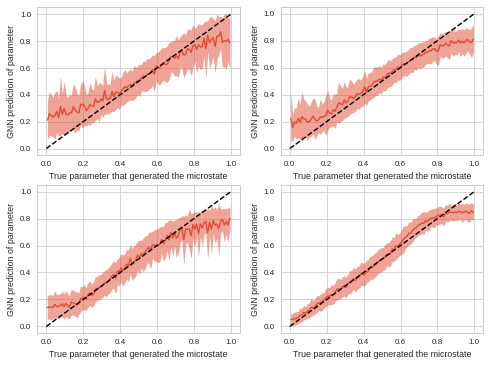

In [37]:

print('validation loss', valid_loss/c)

fig, axs = plt.subplots(2,2, figsize=(8, 6), facecolor='w', edgecolor='k')  

axs = axs.ravel()
for pred_i in range(4):

    pred_vals = np.array([pp[:,pred_i] for pp in pred_list]).flatten()
    true_vals = np.array([tt[:,pred_i] for tt in true_values]).flatten()

    bin_means, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,bins=100)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    bin_stds, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,statistic='std',bins=100)


    axs[pred_i].plot(bin_centers,bin_means,c='C0')

    axs[pred_i].fill_between(bin_centers,bin_means-bin_stds,bin_means+bin_stds,color='C0',alpha=0.5)

    xx = np.linspace(0,true_vals.max(),10)
    axs[pred_i].plot(xx,xx,c='k',ls='--')

    axs[pred_i].set_ylabel('GNN prediction of parameter')
    axs[pred_i].set_xlabel('True parameter that generated the microstate')

plt.show()

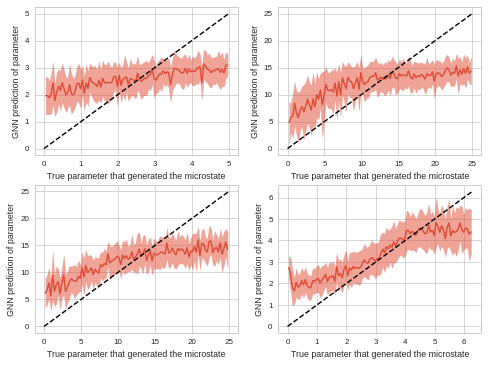

In [30]:
fig, axs = plt.subplots(2,2, figsize=(8, 6), facecolor='w', edgecolor='k')  

axs = axs.ravel()
for pred_i in range(4):

    pred_vals = np.array([pp[:,pred_i] for pp in pred_list]).flatten()
    true_vals = np.array([tt[:,pred_i] for tt in true_values]).flatten()

    bin_means, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,bins=100)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    bin_stds, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,statistic='std',bins=100)


    axs[pred_i].plot(bin_centers,bin_means,c='C0')

    axs[pred_i].fill_between(bin_centers,bin_means-bin_stds,bin_means+bin_stds,color='C0',alpha=0.5)

    xx = np.linspace(0,true_vals.max(),10)
    axs[pred_i].plot(xx,xx,c='k',ls='--')

    axs[pred_i].set_ylabel('GNN prediction of parameter')
    axs[pred_i].set_xlabel('True parameter that generated the microstate')

plt.show()

In [15]:
len(pred_list)
len(true_values)
true_values = true_values[:-1]

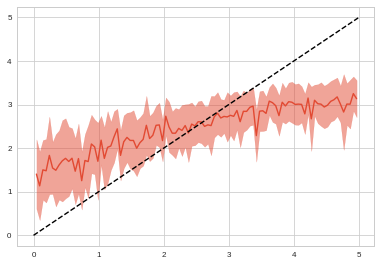

In [18]:
pred_vals = np.array([pp[:] for pp in pred_list]).flatten()
true_vals = np.array([tt[:] for tt in true_values]).flatten()

bin_means, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,bins=100)
bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

bin_stds, bin_edges, binnumber = stats.binned_statistic(true_vals, pred_vals,statistic='std',bins=100)


plt.plot(bin_centers,bin_means,c='C0')

plt.fill_between(bin_centers,bin_means-bin_stds,bin_means+bin_stds,color='C0',alpha=0.5)

xx = np.linspace(0,true_vals.max(),10)
plt.plot(xx,xx,c='k',ls='--')


plt.show()

In [22]:
databatch[0][2].numpy()[:,0]

array([0.58265007, 0.5272711 , 0.9286015 , ..., 0.2864887 , 0.1562759 ,
       0.45944393], dtype=float32)

In [23]:
databatch[1]

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0.8984375, 0.8984375, 0.8984375, 0.8984375, 0.8984375, 0.8984375,
       0.8984375, 0.8984375, 0.8984375, 0.8984375, 0.8984375, 0.8984375,
       0.8984375, 0.8984375, 0.8984375, 0.8984375, 0.8984375, 0.8984375,
       0.8984375, 0.8984375, 0.8984375, 0.8984375, 0.8984375, 0.8984375,
       0.8984375, 0.8984375, 0.8984375, 0.8984375, 0.8984375, 0.8984375,
       0.8984375, 0.8984375], dtype=float32)>

In [13]:
gnn_model(databatch[0])

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[2.467051 ],
       [2.357711 ],
       [2.4625833],
       [2.4757104],
       [2.4018304],
       [2.4050841],
       [2.4386435],
       [2.406125 ],
       [2.4612403],
       [2.4512012],
       [2.4497623],
       [2.5776982],
       [2.4262905],
       [2.5640824],
       [2.5037014],
       [2.4454665],
       [2.4040415],
       [2.4990015],
       [2.4528713],
       [2.5790193],
       [2.4296346],
       [2.487024 ],
       [2.4103086],
       [2.4912677],
       [2.396181 ],
       [2.4755523],
       [2.4945428],
       [2.3429782],
       [2.6824603],
       [2.3919733],
       [2.5966809],
       [2.5389013]], dtype=float32)>

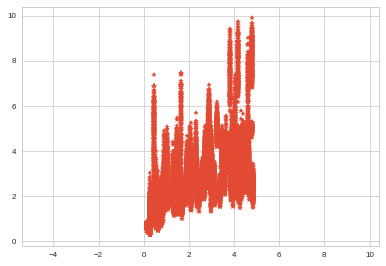

array([5.4720087, 2.8682985, 3.9293559, ..., 4.613968 , 2.0860014,
       1.8668659], dtype=float32)

In [5]:
targets =[]
nnds = []
c=0
for data_batch in parsed_train_dataset:
    targets.append(data_batch[1].numpy())
    dist = data_batch[0][4].numpy()
    dist[dist==0]=1000
    dist = np.min(dist,axis=-1)
    dist = np.mean(dist,axis=-1)
    nnds.append(dist)
    if c > 1000: break
    c=c+1

    
targets = np.array(targets).flatten()

nnds = np.array(nnds).flatten()

plt.plot(targets,nnds,'*')
plt.axis('equal')
plt.show()
nnds

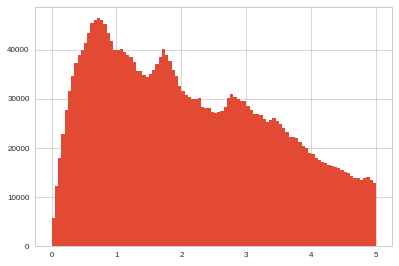

In [4]:

plt.hist(nnds.flatten(),range=(0,5),bins=100)
plt.show()

In [3]:
class PreprocessingLayer(tf.keras.layers.Layer):
    def __init__(self, L):
        super(PreprocessingLayer, self).__init__()
        self._L = L
        

    #@tf.function(input_signature=([tf.TensorSpec(shape=(None,None,2), dtype=tf.float32),tf.TensorSpec(shape=(None,None,2), dtype=tf.float32),tf.TensorSpec(shape=(None,None,2), dtype=tf.float32)]))
    def call(self, inputs):
        
        X, V, A = inputs
        # node features xpos, ypos, xvel, yvel
        # edge features distance, rel angle to receiver

        Xx = tf.expand_dims(X[...,0],-1)
        dx = -Xx + tf.linalg.matrix_transpose(Xx)
        dx = tf.where(dx>0.5*self._L, dx-self._L, dx)
        dx = tf.where(dx<-0.5*self._L, dx+self._L, dx)

        Xy = tf.expand_dims(X[...,1],-1)
        dy = -Xy + tf.linalg.matrix_transpose(Xy)
        dy = tf.where(dy>0.5*self._L, dy-self._L, dy)
        dy = tf.where(dy<-0.5*self._L, dy+self._L, dy)

        Vx = tf.expand_dims(V[...,0],-1)
        dvx = -Vx + tf.linalg.matrix_transpose(Vx)

        Vy = tf.expand_dims(V[...,1],-1)
        dvy = -Vy + tf.linalg.matrix_transpose(Vy)

        angles = tf.expand_dims(tf.math.atan2(V[...,1],V[...,0]),-1)
        angle_to_neigh = tf.math.atan2(dy, dx)

        rel_angle_to_neigh = angle_to_neigh - angles

        dist = tf.math.sqrt(tf.square(dx)+tf.square(dy))
        #print(tf.reduce_mean(dist,axis=[1,2]))
        interaction_radius = 25.0# tf.reduce_mean(dist,axis=[1,2],keepdims=True)
        adj_matrix = tf.where(dist<interaction_radius, tf.ones_like(dist,dtype=tf.int32), tf.zeros_like(dist,dtype=tf.int32))
        adj_matrix = tf.linalg.set_diag(adj_matrix, tf.zeros(tf.shape(adj_matrix)[:2],dtype=tf.int32))
        sender_recv_list = tf.where(adj_matrix)
        n_edge = tf.reduce_sum(adj_matrix, axis=[1,2])
        n_node = tf.ones_like(n_edge)*tf.shape(adj_matrix)[-1]
        
        output_i = tf.repeat(tf.range(tf.shape(adj_matrix)[0]),n_node)
        #g_globals = tf.zeros_like(n_edge,dtype=tf.float32) 

        senders =tf.squeeze(tf.slice(sender_recv_list,(0,1),size=(-1,1)))+ tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]
        receivers = tf.squeeze(tf.slice(sender_recv_list,(0,2),size=(-1,1))) + tf.squeeze(tf.slice(sender_recv_list,(0,0),size=(-1,1)))*tf.shape(adj_matrix,out_type=tf.int64)[-1]

        output_a = tf.sparse.SparseTensor(indices=tf.stack([senders,receivers],axis=1), values = tf.ones_like(senders),dense_shape=[tf.shape(output_i)[0],tf.shape(output_i)[0]])
        edge_distance = tf.expand_dims(tf.gather_nd(dist/self._L,sender_recv_list),-1)
        edge_x_distance =  tf.expand_dims(tf.gather_nd(tf.math.cos(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading
        edge_y_distance =  tf.expand_dims(tf.gather_nd(tf.math.sin(rel_angle_to_neigh),sender_recv_list),-1)  # neigbour position relative to sender heading

        edge_x_orientation =  tf.expand_dims(tf.gather_nd(dvx,sender_recv_list),-1)  # neigbour velocity relative to sender heading
        edge_y_orientation =  tf.expand_dims(tf.gather_nd(dvy,sender_recv_list),-1)  # neigbour velocity relative to sender heading


        output_e = tf.concat([edge_distance,edge_x_distance,edge_y_distance,edge_x_orientation,edge_y_orientation],axis=-1)
        #edges = tf.concat([edge_distance,edge_x_distance,edge_y_distance],axis=-1)

        node_positions = tf.reshape(X,(-1,2))
        node_positions = (node_positions - (self._L/2.))/self._L
        node_velocities = tf.reshape(V,(-1,2))
        node_accelerations = tf.reshape(A,(-1,2))

        output_x = tf.concat([node_velocities,node_accelerations],axis=-1)

        #input_graphs = gn.graphs.GraphsTuple(nodes=nodes,edges=edges,globals=None,receivers=receivers,senders=senders,n_node=n_node,n_edge=n_edge)
        output_x.set_shape((None,4))
        #input_graphs = utils_tf.set_zero_global_features(input_graphs,self._output_size)
        return output_x, output_a, output_e, output_i

layer = PreprocessingLayer(200)

In [7]:
for data_batch in parsed_train_dataset.take(1):
    break

In [8]:
pos = Input(shape=(None,2))
vel = Input(shape=(None,2))
acc = Input(shape=(None,2))

output = PreprocessingLayer(200)([pos,vel,acc])

pre_model = Model(inputs=[pos,vel,acc], outputs=output)




In [9]:
pre_model(data_batch[0])

(<tf.Tensor: shape=(3200, 4), dtype=float32, numpy=
 array([[ 0.29997566,  0.00382304,  0.9996662 , -0.02583462],
        [-0.01991282,  0.29933843,  0.9969374 ,  0.07820405],
        [ 0.11016256, -0.27904162,  0.9999675 ,  0.00806098],
        ...,
        [ 0.10993403, -0.27913174,  0.9998272 ,  0.01858908],
        [ 0.21617502,  0.20801051,  0.9979382 ,  0.06418203],
        [ 0.20362227,  0.22031339,  0.99911094,  0.04215819]],
       dtype=float32)>,
 <tf.Tensor: shape=(84744, 5), dtype=float32, numpy=
 array([[ 1.12213850e-01, -4.51653123e-01,  8.92193615e-01,
         -1.25891268e-02,  8.22523832e-02],
        [ 8.67634416e-02, -9.76646423e-01,  2.14852884e-01,
         -5.82575798e-04,  1.52502619e-02],
        [ 1.23074643e-01,  5.22891402e-01,  8.52399349e-01,
         -2.71052420e-02,  1.20843463e-01],
        ...,
        [ 4.29599993e-02,  7.30072141e-01, -6.83370113e-01,
         -1.17986724e-01,  6.72045499e-02],
        [ 1.25483926e-02,  9.09779668e-01, -4.15091515e-

In [24]:
learning_rate = 1e-3  # Learning rate


n_out = 4
n_feat_node=4
n_feat_edge=5

X_in = Input(shape=(n_feat_node,))
A_in = Input(shape=(None,), sparse=True)
E_in = Input(shape=(n_feat_edge,))
I_in = Input(shape=(), dtype=tf.int64)

X_1 = ECCConv(32, activation="relu")([X_in, A_in, E_in])
X_2 = ECCConv(32, activation="relu")([X_1, A_in, E_in])
X_3 = GlobalAvgPool()([X_2, I_in])
output = Dense(n_out, activation="sigmoid")(X_3)

gnn_model = Model(inputs=[X_in, A_in, E_in, I_in], outputs=output)


In [12]:
all_output = gnn_model(pre_model.outputs)

model = Model(pre_model.inputs,all_output)

In [13]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
preprocessing_layer_2 (Preproce ((None, 4), (None, N 0           input_1[0][0]                    
                                                                 input_2[0][0]              

In [15]:
tf.data.DatasetSpec.from_value(parsed_train_dataset)

DatasetSpec(((TensorSpec(shape=(32, None, 2), dtype=tf.float32, name=None), TensorSpec(shape=(32, None, 2), dtype=tf.float32, name=None), TensorSpec(shape=(32, None, 2), dtype=tf.float32, name=None)), TensorSpec(shape=(32, 4), dtype=tf.float32, name=None)), TensorShape([]))

In [8]:
#data_batch['inputs']
n_out=4
learning_rate=1e-3

# pos = Input(shape=(None,2))
# vel = Input(shape=(None,2))
# acc = Input(shape=(None,2))

# X_in, A_in, E_in, I_in = PreprocessingLayer(200)([pos,vel,acc])

X_in = Input(shape=(F,), name='X_in', dtype=dtype_str)
A_in = Input(shape=(None,), sparse=True, name='A_in', dtype=dtype_str)
E_in = Input(shape=(S,), name='E_in', dtype=dtype_str)
I_in = Input(shape=(1,), name='I_in', dtype='int32')

X_1 = ECCConv(32, activation="relu")([X_in, A_in, E_in])
X_2 = ECCConv(32, activation="relu")([X_1, A_in, E_in])
X_3 = GlobalAvgPool()([X_2, I_in])
output = Dense(n_out, activation="sigmoid")(X_3)

model = Model(inputs=[pos,vel,acc], outputs=output)
optimizer = Adam(learning_rate)
loss_fn = MeanSquaredError()


In [17]:
model.build(input_shape=((None,2),(None,2),(None,2)))

(<tf.Tensor: shape=(3200, 4), dtype=float32, numpy=
 array([[-0.6602842 , -0.75101584,  0.99888265,  0.04725935],
        [ 0.47222283, -0.8814792 ,  0.99602693,  0.08905262],
        [ 0.89416176, -0.44774413,  0.9999219 ,  0.01249791],
        ...,
        [ 0.29892108, -0.02542047,  0.9981405 , -0.06095469],
        [ 0.2996737 ,  0.01398818,  0.9999598 , -0.00896081],
        [ 0.29997778, -0.00365305,  0.99932873, -0.03663413]],
       dtype=float32)>,
 <tf.Tensor: shape=(175834, 5), dtype=float32, numpy=
 array([[ 1.85661726e-02,  9.65729415e-01, -2.59551018e-01,
          1.55444598e+00,  3.03271711e-01],
        [ 9.79329273e-02, -5.61340712e-02,  9.98423219e-01,
         -3.37642431e-01,  8.15377414e-01],
        [ 1.50080782e-03,  8.15061450e-01, -5.79374611e-01,
          1.60548592e+00,  1.07750297e+00],
        ...,
        [ 7.24744871e-02,  7.79586375e-01, -6.26294792e-01,
         -6.35087490e-04, -1.61952451e-02],
        [ 1.13245055e-01,  6.48329794e-01, -7.61359692e

In [25]:

################################################################################
# Fit model
################################################################################
@tf.function()#input_signature=[[tf.TensorSpec(shape=(None,None,2), dtype=tf.float32),tf.TensorSpec(shape=(None,None,2), dtype=tf.float32),tf.TensorSpec(shape=(None,None,2), dtype=tf.float32)],tf.TensorSpec(shape=(None,4), dtype=tf.float32)], experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = gnn_model(inputs, training=True)
        loss = loss_fn(target, predictions) #+ sum(model.losses)
    gradients = tape.gradient(loss, gnn_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, gnn_model.trainable_variables))
    return loss



In [26]:
loss_fn = MeanSquaredError()
optimizer = Adam(learning_rate)
learning_rate=1e-3


In [27]:

step = loss = 0

for batch in parsed_train_dataset:
    step += 1
    inputs, target = batch
    #inputs = layer(inputs)

    loss += train_step(inputs,target)
    print(loss.numpy()/step)

87.37239837646484
93.6590347290039
88.35610961914062
89.49259185791016
91.6520751953125
86.03232828776042
85.99046979631696
84.85694885253906
86.88281928168402
87.62980346679687
88.25322931463069
88.580078125
88.86525315504808
89.17442103794643
90.15537109375
89.68606567382812


KeyboardInterrupt: 

In [ ]:

for batch in loader_tr:
    step += 1
    loss += train_step(*batch)
    if step == loader_tr.steps_per_epoch:
        step = 0
        print("Loss: {}".format(loss / loader_tr.steps_per_epoch))
        loss = 0

################################################################################
# Evaluate model
################################################################################
print("Testing model")
loss = 0
for batch in loader_te:
    inputs, target = batch
    predictions = model(inputs, training=False)
    loss += loss_fn(target, predictions)
loss /= loader_te.steps_per_epoch
print("Done. Test loss: {}".format(loss))

In [24]:
learning_rate = 1e-3  # Learning rate


n_out = 4
n_feat_node=4
n_feat_edge=5

X_in = Input(shape=(n_feat_node,))
A_in = Input(shape=(None,), sparse=True)
E_in = Input(shape=(n_feat_edge,))
I_in = Input(shape=(), dtype=tf.int64)

X_1 = ECCConv(32, activation="relu")([X_in, A_in, E_in])
X_2 = ECCConv(32, activation="relu")([X_1, A_in, E_in])
X_3 = GlobalAvgPool()([X_2, I_in])
output = Dense(n_out, activation="sigmoid")(X_3)

model = Model(inputs=[X_in, A_in, E_in, I_in], outputs=output)
optimizer = Adam(learning_rate)
loss_fn = MeanSquaredError()

In [25]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
ecc_conv_6 (ECCConv)            (None, 32)           928         input_10[0][0]                   
                                                                 input_11[0][0]             

In [63]:
#processed_g = layer(data_batch['inputs'])

#model(data_batch[0])
model.build(input_shape=[(None,2),(None,2),(None,2)])

In [55]:
epochs = 10  # Number of training epochs
batch_size = 32  # Batch size
################################################################################
# Build model
################################################################################
class GNNNet(Model):
    def __init__(self,n_out=4,mp_steps=5):
        super().__init__()
        self.preprocess = PreprocessingLayer(200)
        self.encoder = ECCConv(32, activation="relu")
        self.process = MessagePassing(aggregate='mean')# 32, activation="relu")
        self.decoder = ECCConv(32, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense = Dense(32, activation="relu")
        self.final = Dense(n_out, activation="sigmoid")
        self.mp_steps=mp_steps
    
    def call(self, inputs):
        x, a, e, i = self.preprocess(inputs)
        #x.set_shape([None,None])
        x = self.encoder([x, a, e])
        
        for _ in range(self.mp_steps):
            x = self.process([x, a, e])
            
        x = self.decoder([x, a, e])
        x = self.global_pool([x, i])
        x = self.dense(x)
        x = self.final(x)

        return x


model = GNNNet()


class GNNNet2(Model):
    def __init__(self,n_out=4,mp_steps=5):
        super().__init__()
        self.preprocess = PreprocessingLayer(200)
        self.encoder = ECCConv(32, activation="relu")
        self.process = MessagePassing(aggregate='mean')# 32, activation="relu")
        self.decoder = ECCConv(32, activation="relu")
        self.global_pool = GlobalAvgPool()
        self.dense = Dense(32, activation="relu")
        self.final = Dense(n_out, activation="sigmoid")
        self.mp_steps=mp_steps
    
    def call(self, inputs):
        x, a, e, i = self.preprocess(*inputs)
        

        return x


model2 = GNNNet2()
optimizer = Adam(learning_rate)
loss_fn = MeanSquaredError()


In [7]:
#model.summary()

Epoch 1/2
   9523/Unknown - 296s 31ms/step - loss: 97.6248

KeyboardInterrupt: 

In [42]:
xx,aa,ee,ii = layer(*a['inputs'])

In [46]:
xx

<tf.Tensor: shape=(3200, 4), dtype=float32, numpy=
array([[ 0.01420234, -0.29966363,  0.9990728 , -0.04305259],
       [-0.11539764, -0.27691767,  0.9998522 ,  0.01719184],
       [-0.18541189, -0.2358441 ,  0.9997369 , -0.02293837],
       ...,
       [ 0.21088402, -0.21337275,  0.99852383, -0.05431493],
       [ 0.06888431,  0.29198453,  0.9986782 ,  0.05139899],
       [ 0.19472411, -0.22821599,  0.9959926 ,  0.08943559]],
      dtype=float32)>

In [57]:
model(a['inputs'])

<tf.Tensor: shape=(32, 4), dtype=float32, numpy=
array([[9.9995530e-01, 4.8791789e-02, 9.9998534e-01, 2.0505816e-02],
       [1.0000000e+00, 3.4196235e-04, 1.0000000e+00, 1.4633950e-03],
       [5.9821326e-01, 4.2001119e-01, 6.7080355e-01, 3.9445329e-01],
       [9.9999177e-01, 1.1323161e-02, 1.0000000e+00, 1.7302482e-04],
       [6.6569734e-01, 2.1566081e-01, 8.1479019e-01, 3.7192801e-01],
       [5.6262076e-01, 3.5664517e-01, 6.4872134e-01, 3.8796154e-01],
       [9.9970740e-01, 5.3109568e-02, 9.9996567e-01, 3.1746940e-03],
       [1.0000000e+00, 1.0839165e-03, 1.0000000e+00, 7.5619464e-04],
       [9.9444360e-01, 9.4893249e-03, 9.9950802e-01, 8.5937725e-03],
       [5.9432930e-01, 4.3507460e-01, 6.4308780e-01, 3.8001046e-01],
       [9.9067897e-01, 3.3200887e-01, 9.9799711e-01, 5.8671191e-02],
       [6.2182903e-01, 3.5682076e-01, 6.9833601e-01, 3.5766926e-01],
       [1.0000000e+00, 3.9554469e-04, 1.0000000e+00, 1.5212449e-03],
       [9.2112792e-01, 6.0706425e-27, 1.0000000e+00, 1

In [51]:
a['inputs']

(<tf.Tensor: shape=(32, 100, 2), dtype=float32, numpy=
 array([[[ 85.635544 ,  63.359848 ],
         [ 97.28568  ,  76.58933  ],
         [109.84356  ,  91.33317  ],
         ...,
         [ 86.603355 ,  64.99302  ],
         [100.54461  ,  88.19793  ],
         [ 97.49204  ,  75.83179  ]],
 
        [[ 78.46085  , 120.0744   ],
         [102.43636  ,  90.808914 ],
         [102.37822  ,  94.574005 ],
         ...,
         [104.72604  , 118.1834   ],
         [113.677505 , 105.09643  ],
         [ 86.6974   ,  83.055275 ]],
 
        [[167.7722   , 163.60008  ],
         [ 26.971184 , 122.473694 ],
         [ 20.551174 , 102.50517  ],
         ...,
         [ 66.71221  ,  20.460861 ],
         [ 88.31101  ,  30.887947 ],
         [ 69.346756 ,  21.521975 ]],
 
        ...,
 
        [[ 91.618225 ,  82.21134  ],
         [119.1858   ,  78.341385 ],
         [ 86.42814  ,  79.6149   ],
         ...,
         [ 94.018326 , 106.12513  ],
         [ 91.81656  ,  82.02696  ],
         [ 87.

In [60]:
from spektral.layers.ops import modes
mode = modes.autodetect_mode(xx, aa)
if mode == modes.SINGLE:
    print('Single!')
elif mode == modes.BATCH:
    print('Batch!')
elif mode == modes.MIXED:
    print('Mixed!')

Single!


In [34]:
model.encoder([xx,aa,ee])

/maths/ctorney/anaconda3/envs/tf_pre/lib/python3.9/site-packages/spektral/layers/convolutional/conv.py:93: UserWarning: The adjacency matrix of dtype <dtype: 'int64'> is incompatible with the dtype of the node features <dtype: 'float32'> and has been automatically cast to <dtype: 'float32'>.
  warnings.warn(


<tf.Tensor: shape=(3200, 32), dtype=float32, numpy=
array([[0.12525703, 5.5691333 , 4.619558  , ..., 0.        , 6.067916  ,
        0.        ],
       [3.8012621 , 6.4534535 , 3.541778  , ..., 0.        , 8.060167  ,
        3.435962  ],
       [0.21417338, 0.        , 0.        , ..., 0.77218795, 0.        ,
        6.107104  ],
       ...,
       [0.15672109, 4.4995646 , 5.4817758 , ..., 0.        , 6.2134595 ,
        0.        ],
       [2.8203251 , 0.24877724, 0.        , ..., 0.        , 0.        ,
        1.3490791 ],
       [2.2659237 , 4.614161  , 6.177508  , ..., 0.        , 6.1549025 ,
        0.        ]], dtype=float32)>

In [31]:
ss
tf.ones_like(ss)

<tf.Tensor: shape=(152416,), dtype=int64, numpy=array([1, 1, 1, ..., 1, 1, 1])>

In [28]:
model.predict(a['inputs'])

ValueError: in user code:

    /maths/ctorney/anaconda3/envs/tf_pre/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1569 predict_function  *
        return step_function(self, iterator)
    <ipython-input-26-f30db82437e0>:22 call  *
        x = self.encoder([x, a, e])
    /maths/ctorney/anaconda3/envs/tf_pre/lib/python3.9/site-packages/spektral/layers/convolutional/conv.py:143 _inner_check_dtypes  *
        return call(inputs, **kwargs)
    /maths/ctorney/anaconda3/envs/tf_pre/lib/python3.9/site-packages/spektral/layers/convolutional/ecc_conv.py:176 call  *
        output = ops.scatter_sum(messages, index_i, N)
    /maths/ctorney/anaconda3/envs/tf_pre/lib/python3.9/site-packages/spektral/layers/ops/scatter.py:6 _wrapper_mm_support  *
        if len(updates.shape) == 3:
    /maths/ctorney/anaconda3/envs/tf_pre/lib/python3.9/site-packages/tensorflow/python/autograph/operators/py_builtins.py:252 len_  **
        return _py_len(s)
    /maths/ctorney/anaconda3/envs/tf_pre/lib/python3.9/site-packages/tensorflow/python/autograph/operators/py_builtins.py:317 _py_len
        return len(s)
    /maths/ctorney/anaconda3/envs/tf_pre/lib/python3.9/site-packages/tensorflow/python/framework/tensor_shape.py:855 __len__
        raise ValueError("Cannot take the length of shape with unknown rank.")

    ValueError: Cannot take the length of shape with unknown rank.


In [18]:
tf.range(32)

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int32)>

In [21]:
ccc = 

In [45]:
tf.shape(ii)[0]#.shape

<tf.Tensor: shape=(), dtype=int32, numpy=3200>